# Does my new central heating boiler help with these crazy high gas prices
*Where we use linear regression with interactions to benchmark the performance of my new central heating boiler in an energy crisis*

# Introduction
During the current gas crisis in Europe I saw my monthly energy bill skyrocket. So, like any nerd type data scientist I started to study the energy usage data to assuage my worries. One of the first things that struck me was that our gas usage was lower than I expected. One of the prime suspects that could cause this was the installation of a new central heating boiler at the end of april 2022. This is the only appliance that uses gas to generate warm water for both showering and our central heating. 

In this article we explore my energy data, and build a regression model that quantifies just how much my new central heating boiler influences my gas usage. 

# Getting the data
The primary source is the website of my energy supplier, Eneco. They allow me to download an Excel sheet with daily energy usage. Note that the Excel sheet I download uses normalised usage data (min-max scaled) as to protect my data privacy:

In [6]:
import pandas as pd
from local_functions import *
from plotnine import *
import calendar

energy_usage = pd.read_excel('data/usage_anonymized.xlsx', index_col=[0])
temperature = read_knmi('data/knmi_weather.txt')
energy_usage.head()

,elec_low,elec_high,gas_usage,elec_usage
Datum,,,,
2014-09-18,0.998149,0.999225,0.153846,0.999422
2014-09-19,0.998149,0.999302,0.153846,0.999463
2014-09-20,0.998766,0.998682,0.076923,0.999422
2014-09-21,0.998766,0.998682,0.153846,0.999422
2014-09-22,0.998149,0.999225,0.076923,0.999422


In addition to my energy usage data I also downloaded daily outside temperatues, as I suspect that this very much influences how much central heating I need at a given moment in time. 

The energy usage data contains both electricity and gas usage, but in this case we are interested in gas usage in cubic metre (m3) only. In addition we merge in the temperature data.

In [39]:
gas_usage = (
    energy_usage['gas_usage']
        .reset_index()
        .merge(temperature.reset_index(), 
                left_on='Datum', right_on='date')
    )
gas_usage.head()

,Datum,gas_usage,date,station,T_gem,T_min,T_max
0,2014-09-18,0.153846,2014-09-18,280,18.6,13.6,25.5
1,2014-09-19,0.153846,2014-09-19,280,17.7,11.8,24.9
2,2014-09-20,0.076923,2014-09-20,280,16.9,10.8,23.9
3,2014-09-21,0.153846,2014-09-21,280,15.4,13.2,18.8
4,2014-09-22,0.076923,2014-09-22,280,12.7,6.0,17.6


To visualise the gas usage over the years, the following plot shows a timeseries:

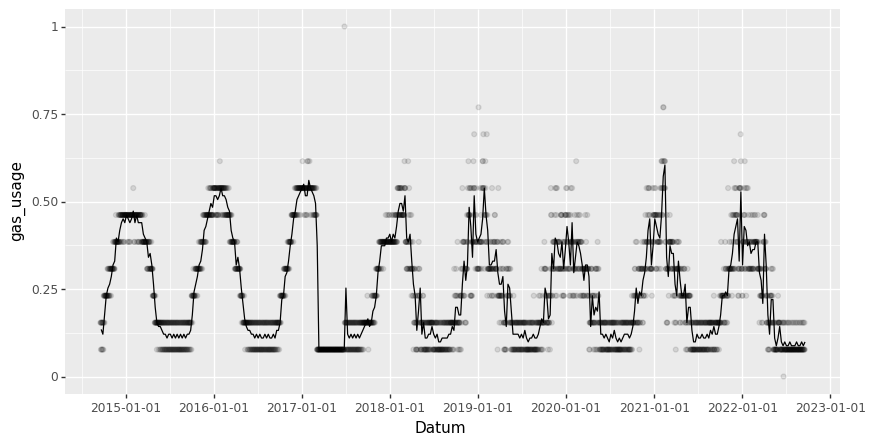

<ggplot: (8735098761436)>

In [38]:
(
    ggplot(gas_usage, aes(x='Datum', y='gas_usage')) 
      + geom_point(alpha=0.1)
      + geom_line(data=energy_usage['gas_usage'].resample('W').mean().reset_index())
      + theme(figure_size=(10,5))
)

where the dots are the daily values, en the line the weekly average. This clearly shows the yearly trend in gas usage with high usage in winter and lower in summer. The daily values accumulate on horizontal lines, this is due to the gas usage being reported in integer increments. This effectively rounds the values. To mitigate this integer effect we resample the whole dataset to weekly summed gas usage and weekly averaged temperatures. 


In [48]:
gas_usage = (
    energy_usage['gas_usage']
      .resample('W').sum().reset_index()
      .merge(temperature.resample('W').mean().reset_index(), left_on='Datum', right_on='date')
)
gas_usage.head()

,Datum,gas_usage,date,station,T_gem,T_min,T_max
0,2014-09-21,0.538462,2014-09-21,280.0,17.542857,12.614286,23.328571
1,2014-09-28,0.846154,2014-09-28,280.0,13.371429,7.128571,17.814286
2,2014-10-05,1.230769,2014-10-05,280.0,15.471429,11.571429,19.671429
3,2014-10-12,1.615385,2014-10-12,280.0,12.885714,9.400000,16.428571
4,2014-10-19,1.769231,2014-10-19,280.0,14.071429,10.557143,17.800000



If we plot the weekly total gas usage versus weekly averaged outside temperature we again see the summer-winter effect:

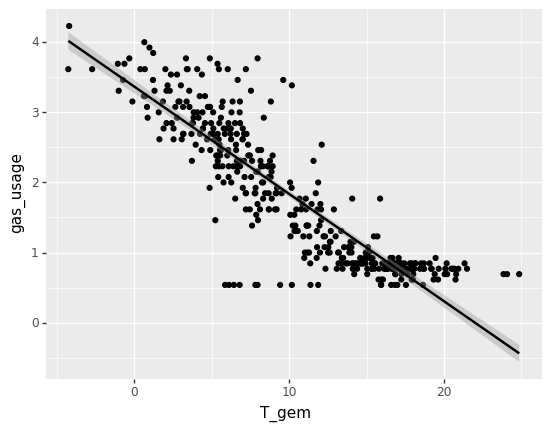

<ggplot: (8735099522919)>

In [49]:
(
    ggplot(gas_usage, aes(x='T_gem', y='gas_usage')) 
      + geom_point()
      + geom_smooth(method='lm')
)

# Benchmarking the central heating boiler
With the data in place, we can start benchmarking the boiler. The following boxplot shows the spread in weekly total gas usage for each month before (red) and after installing the new boiler:

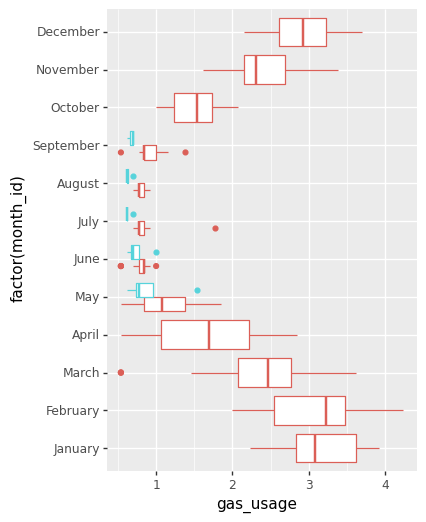

<ggplot: (8735098914804)>

In [50]:
gas_usage["month_id"] = pd.Categorical(gas_usage['Datum'].dt.strftime('%B'), categories=calendar.month_name[1:])
gas_usage["year_id"] = pd.Categorical(gas_usage['Datum'].dt.strftime('%Y'))
gas_usage['post_install'] = gas_usage['Datum'] > 'May 2022'

(
    ggplot(gas_usage)
      + geom_boxplot(aes(x='factor(month_id)', y='gas_usage', color='factor(post_install)'), position='dodge', show_legend=False)
      #+ scale_color_discrete(guide=False)
      + coord_flip()
      + theme(figure_size=(4,6))
)

Which shows us the first hint that the new boiler uses less gas than the old one. If we plot the same graph of temperature versus gas usage, and draw a regression line before and after this confirms that the new boiler seems to be using less gas. In addition, it shows that the effect seems to scale with temperature. However, the post install data is still very limited and not a lot of week are included where our heating was triggered because of the cold. But given the very high gas prices currently, this provides me with some hope that we can get through the winter with less gas than the previous winter. 

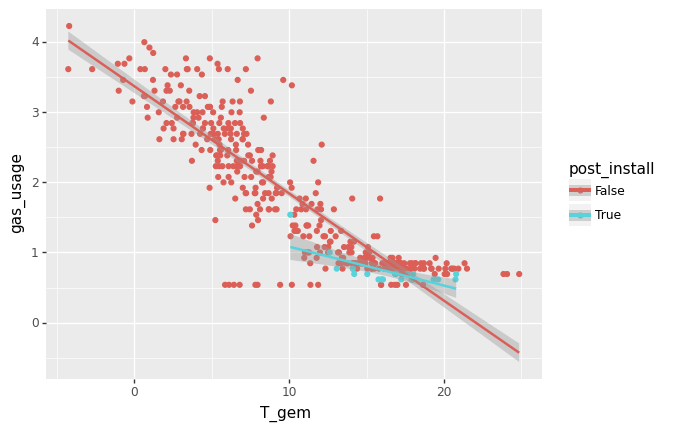

<ggplot: (8735098348563)>

In [51]:
(
    ggplot(gas_usage, aes(x='T_gem', y='gas_usage', color='post_install')) 
      + geom_point()
      + geom_smooth(method='lm')
)

To quantify the regression the line above we execute the following statsmodels code. Note that in the formula we use `T_gem * C(post_install)`, this signals to statsmodels that we want there to be an interaction `T_gem` and post_install. This effectively means the relationship between `gas_usage` and `T_gem` can be different for the two values of `C(post_install)`, resulting in the two lines in the plot above. Running the code yields:

In [54]:
import statsmodels.formula.api as smf

res = smf.ols(formula='gas_usage ~ T_gem * C(post_install)', data=gas_usage).fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              gas_usage   R-squared:                       0.778
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     483.7
Date:                Mon, 19 Sep 2022   Prob (F-statistic):          6.86e-135
Time:                        19:56:04   Log-Likelihood:                -277.17
No. Observations:                 418   AIC:                             562.3
Df Residuals:                     414   BIC:                             578.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

where the coefficients need to be interpreted as:

- `Intercept` the (anonimized) gas usage at zero degrees centigrade
- `C(post_install)[T.True]` at zero degrees, the new boiler uses 1.73 less gas
- `T_gem` for each degree increase in temperature the gas usage drops 0.15
- `T_gem:C(post_install)[T.True]` for each degree increase in temperature the benefit of the new boiler in terms of gas usage drops by 0.09

So the absolute benefit of the new boiler is a lot bigger when it is cold. Again, the data post installation of the new boiler is scarce so the results should be tested with more data. 